# Portfolio Optimization for Asset Selection


We will rigorously end-to-end design a Portfolio of stocks  from data acquisition, alpha and risk factor modeling, and porfolio optimization.


- First, we will build and evaluate an alpha factor strategy.
- Second, we model a risk factor using the Fama-French 5-factor model.
- Third we develop a portfolio optimization to construction our portfolio.



In [2]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import pandas_datareader.data as web

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
idx = pd.IndexSlice


# Alpha Factor Construction


The hypothesis is based on the fact that stocks that have been oscillating in a given range on normnal market conditions tend to break out of that range due to strong external impacts such as market pressure from large investors of significant news release. 

Such move out of the range tend to attract other investors interest. Indeed, due to behavioural bias of herding (`Heard Behavior`), other investrors tend to build positions which also reinforce the continuation of the asset's trend.

Therefore, we will use the `close`, `highs` and `lows` prices of assets to construct the corresponding alpha factor. 

To model the alpha factors, we will compare present market closing prise to the maximum high price and minimum low price over a window of days.

In [3]:
import alpha_strategy
import optimization_module

# View Computed Highs and Lows Patterns

Visualize past 24-days max highs, min lows, and close prices.

In [4]:
data = alpha_strategy.get_data('historic_data.csv')
data

Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2019-08-08 AAPL     49.025684   50.857498   50.882500   49.847500   50.049999   
           AEM      52.518192   59.400002   59.599998   57.250000   57.820000   
           AMD      33.919998   33.919998   34.270000   31.480000   31.530001   
           AMZN     91.644501   91.644501   91.712997   89.905502   90.300003   
           BAC      25.062557   28.379999   28.490000   28.070000   28.110001   
...                       ...         ...         ...         ...         ...   
2024-08-08 NVDA    104.970001  104.970001  105.500000   97.519997  102.000000   
           PFE      28.760000   28.760000   29.010000   28.540001   28.930000   
           TDS      20.760000   20.760000   20.900000   20.200001   20.620001   
           TSLA    198.839996  198.839996  200.699997  192.039993  195.699997   
           WDFC    253.089996  253.089996  254.500000  251.449997  252.250000   

                      Volume  
Date       Ticker             
2019-08-08 AAPL    108038000  
           AEM       1513000  
           AMD     167278800  
           AMZN     74024000  
           BAC      53141900  
...                      ...  
2024-08-08 NVDA    391910000  
           PFE      32094400  
           TDS       1331900  
           TSLA     65033900  
           WDFC        53000  

[26439 rows x 6 columns]

In [6]:
past_days=24
df_for_view, _  = alpha_strategy.model_alpha_factor(data, past_days)
df_for_view = df_for_view.groupby('Ticker').apply(lambda x: x).droplevel(2)
df_for_view = df_for_view.drop(['past_days_ret', 'alpha_factor'], axis=1)
df_for_view

Adj Close  highest_highs  lowest_lows
Ticker Date                                              
AAPL   2019-09-12   53.967930      55.927502    49.787498
       2019-09-13   52.918026      56.605000    49.787498
       2019-09-16   53.196224      56.605000    49.787498
       2019-09-17   53.389755      56.605000    49.917500
       2019-09-18   53.890511      56.605000    49.917500
...                       ...            ...          ...
WDFC   2024-08-02  255.960007     272.489990   211.029999
       2024-08-05  249.339996     272.489990   211.029999
       2024-08-06  249.509995     272.489990   211.029999
       2024-08-07  249.779999     272.489990   211.029999
       2024-08-08  253.089996     272.489990   211.029999

[25935 rows x 3 columns]

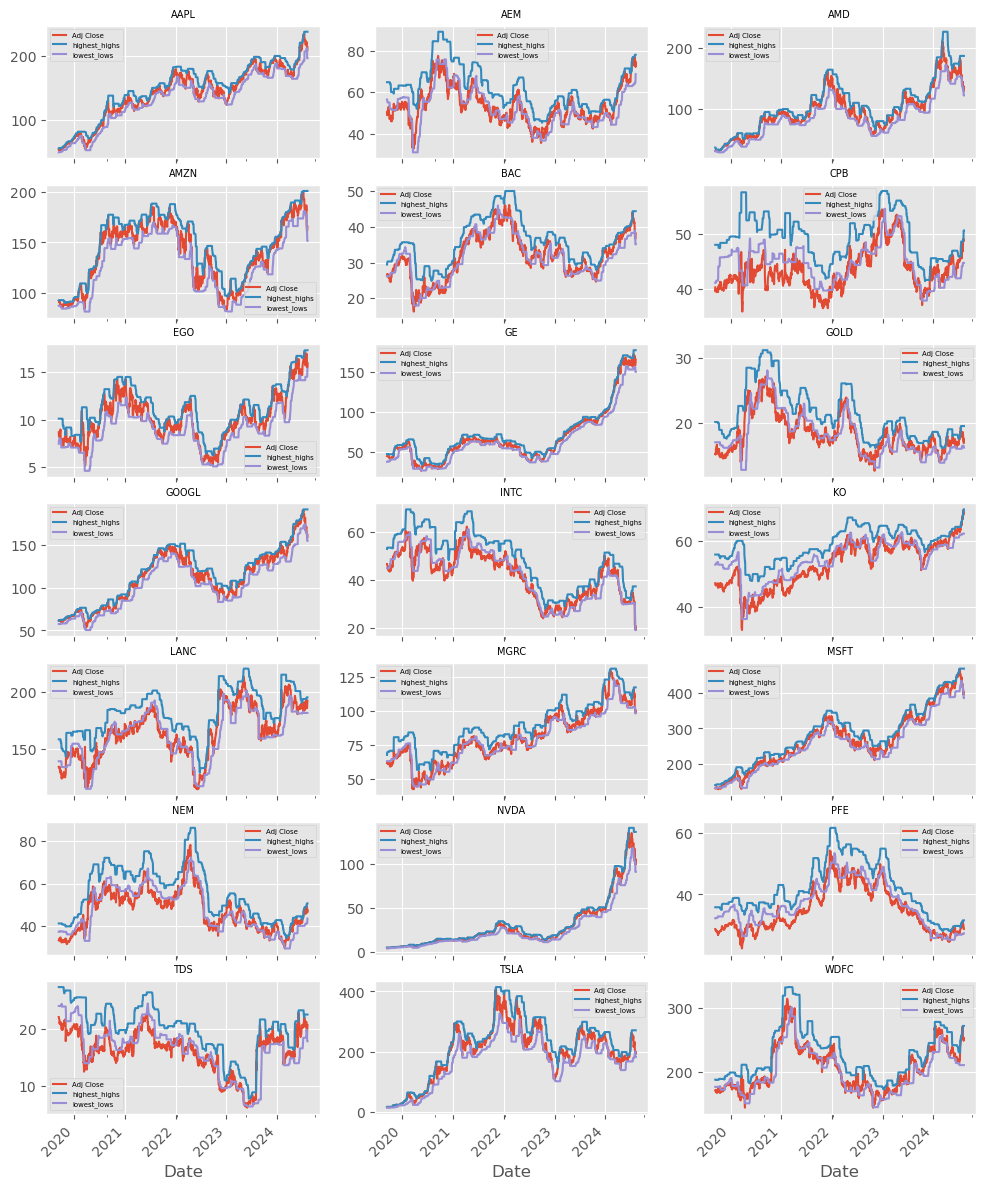

In [7]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(12, 16), sharex=True)
axes = axes.flatten()
for i, ticker in enumerate(df_for_view.index.unique('Ticker')):
    ax = axes[i]
    df_for_view.loc[ticker, :].plot(ax=ax)
    ax.set_title(ticker, fontsize=7)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.legend(fontsize=5)

    plt.setp(ax.get_xticklabels(), rotation=45)                         

We build the alpha by considering  the past 11 days of highs, lows and returns.

- The alpha model suggest `long position` when present closing price is `higher than the 11-past-days max high`.
- The alpha model suggest `short position` when present closing price is `lower than the 11-past-days min low`.
- if neither of the above condition occurs, then the alpha model suggest a `momentum strategy`.

In [8]:
_, raw_alpha = alpha_strategy.model_alpha_factor(data, past_days=11)
raw_alpha

alpha_factor
Date       Ticker              
2019-08-23 AAPL       -0.766647
           AEM        -2.564365
           AMD        -0.000792
           AMZN       -0.379997
           BAC        -2.834175
...                         ...
2024-08-08 NVDA        0.001144
           PFE         0.000807
           TDS        -0.000875
           TSLA        0.010467
           WDFC        0.000562

[26208 rows x 1 columns]

In [9]:
de_mean = lambda x: x - x.groupby('Date').transform('mean')
ranking = lambda x: x.unstack('Ticker').rank(axis=1, ascending=True).stack('Ticker')
z_scoring = lambda x: (x.sub(x.groupby('Date').transform('mean'))).div(x.groupby('Date').transform('std'))

In [10]:
alpha_factor = z_scoring(ranking(de_mean(raw_alpha)))
alpha_factor

alpha_factor
Date       Ticker              
2019-08-23 AAPL        0.322329
           AEM         0.161165
           AMD         1.289317
           AMZN        0.805823
           BAC         0.000000
...                         ...
2024-08-08 NVDA        0.805823
           PFE         0.644658
           TDS        -1.289317
           TSLA        1.611646
           WDFC        0.322329

[26208 rows x 1 columns]

# Evaluate Alpha Factor on Different Holding Periods

In [12]:
import alphalens as al

In [13]:
periods=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
prices = data['Adj Close']
prices = prices.unstack()
alpha_data = al.utils.get_clean_factor_and_forward_returns(prices=prices, 
                                                           factor=alpha_factor,
                                                           periods=periods
                                                           )                                                                                                                 

Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [14]:
alpha_data

1D        2D        3D        4D        5D        6D  \
date       asset                                                               
2019-08-23 AAPL   0.018999  0.007501  0.014262  0.031435  0.030103  0.015100   
           AEM    0.009419  0.040597  0.037837  0.006841  0.018393  0.029457   
           AMD    0.025051  0.022343  0.041977  0.064658  0.064658  0.046039   
           AMZN   0.011002  0.006979  0.008362  0.021022  0.015243  0.022988   
           BAC    0.011711  0.000000  0.014356  0.032490  0.039290  0.021911   
...                    ...       ...       ...       ...       ...       ...   
2024-07-25 NVDA   0.006947 -0.006145 -0.076149  0.042216 -0.027342 -0.044621   
           PFE    0.033938  0.032258  0.054771  0.026210  0.029906  0.022513   
           TDS    0.022450  0.019034  0.042460  0.034651  0.030259 -0.023426   
           TSLA  -0.002043  0.053803  0.010760  0.053666 -0.015392 -0.057117   
           WDFC   0.028544  0.040485  0.047111  0.007743 -0.010401 -0.014022   

                        7D        8D        9D       10D    factor  \
date       asset                                                     
2019-08-23 AAPL   0.032323  0.052507  0.052408  0.056899  0.322329   
           AEM    0.043776 -0.001945 -0.032209 -0.061009  0.161165   
           AMD    0.047732  0.066351  0.034529  0.032498  1.289317   
           AMZN   0.029149  0.052068  0.047948  0.046713  0.805823   
           BAC    0.038534  0.069337  0.054506  0.088731  0.000000   
...                    ...       ...       ...       ...       ...   
2024-07-25 NVDA  -0.105362 -0.071518 -0.119077 -0.065105 -1.128152   
           PFE   -0.000672 -0.014785 -0.030578 -0.033602  0.483494   
           TDS   -0.070278 -0.037091 -0.003904  0.013177 -0.322329   
           TSLA  -0.097026 -0.089035 -0.129353 -0.097208  1.128152   
           WDFC  -0.039522 -0.038868 -0.037827 -0.025077  1.611646   

                  factor_quantile  
date       asset                   
2019-08-23 AAPL                 3  
           AEM                  3  
           AMD                  5  
           AMZN                 4  
           BAC                  3  
...                           ...  
2024-07-25 NVDA                 1  
           PFE                  4  
           TDS                  2  
           TSLA                 5  
           WDFC                 5  

[25997 rows x 12 columns]

# Factor Returns

In [15]:
factor_returns = al.performance.factor_returns(alpha_data)
factor_returns.dropna(inplace=True)
factor_returns

,1D,2D,3D,4D,5D,6D,7D,8D,9D,10D
date,,,,,,,,,,
2019-08-23,0.000518,0.011297,0.008400,0.007315,0.008652,0.005990,0.016813,0.017856,0.005591,0.005705
2019-08-26,0.011641,0.008110,0.007057,0.006522,0.002934,0.012989,0.015196,0.005198,0.005113,0.001945
2019-08-27,-0.004021,-0.006901,-0.007514,-0.010136,0.000606,0.000180,-0.010854,-0.012362,-0.016964,-0.013487
2019-08-28,-0.003702,-0.004591,-0.007267,0.003302,0.001682,-0.009273,-0.010102,-0.014383,-0.010747,-0.013531
2019-08-29,-0.001084,-0.005538,0.004788,0.009354,-0.000118,0.000518,-0.002955,0.001642,0.000390,-0.000452
...,...,...,...,...,...,...,...,...,...,...
2024-07-19,0.006890,0.012719,-0.000008,0.009485,0.012403,0.016905,0.008549,0.018222,0.018552,0.031214
2024-07-22,0.003490,-0.010404,0.002419,-0.001281,0.000378,-0.005106,0.001767,-0.002972,0.008431,0.007803
2024-07-23,-0.013916,-0.006437,-0.002787,0.001125,-0.007647,0.003763,0.001279,0.018789,0.017979,0.022783


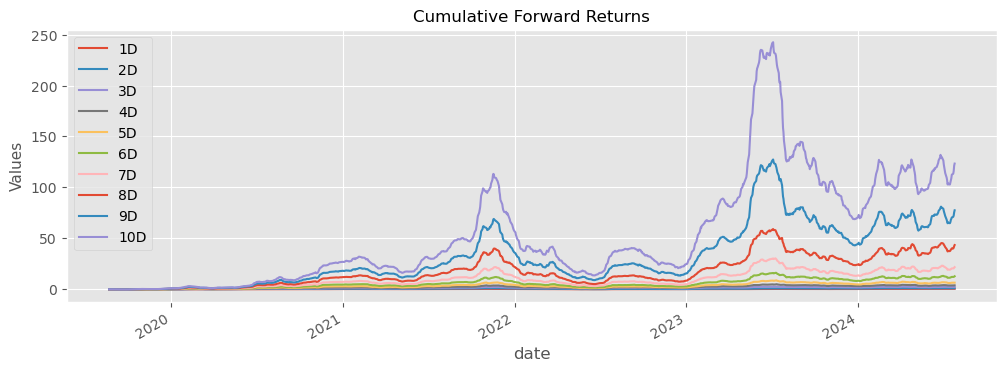

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
((1+factor_returns).cumprod() - 1).plot(ax=axes)
axes.set_ylabel('Values', fontsize=11)
axes.set_title('Cumulative Forward Returns', fontsize=12)
plt.show()

It appears that the 10D holding periods yields the highst returns

# Sharpe Ratio

In [17]:
Rf = 0.0017
sharpe_ratio = np.sqrt(252)*(factor_returns.mean() - Rf)/factor_returns.std()
sharpe_ratio = pd.DataFrame(sharpe_ratio, columns=['sharpe_ratio'])

print(sharpe_ratio)

     sharpe_ratio
1D      -2.916373
2D      -1.678185
3D      -0.809136
4D      -0.337058
5D       0.066867
6D       0.514752
7D       0.819978
8D       1.189745
9D       1.473832
10D      1.657910


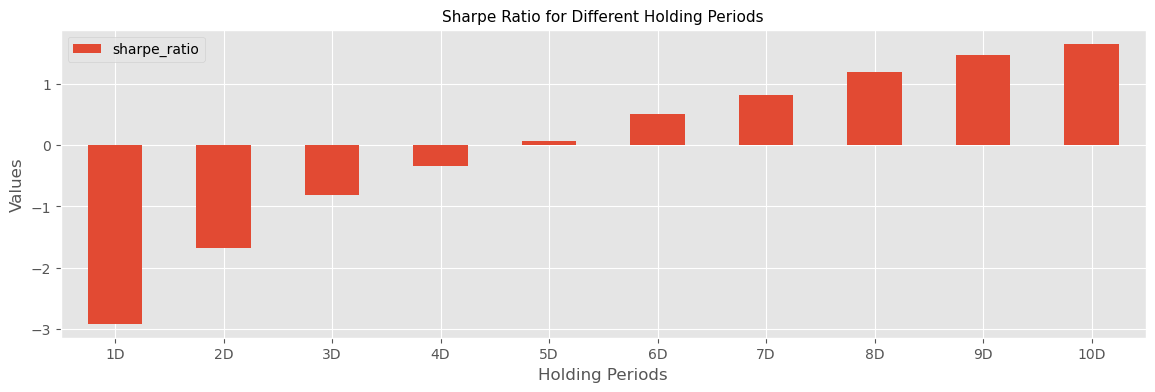

In [18]:
fig, ax = plt.subplots(figsize=(14, 4))

sharpe_ratio.plot.bar(ax=ax)
ax.set_xlabel('Holding Periods', fontsize=12)
ax.set_ylabel('Values', fontsize=12)
ax.set_title('Sharpe Ratio for Different Holding Periods', fontsize=11)
ax.legend()
plt.setp(ax.get_xticklabels(), rotation=0)
plt.show()

# Quantile Returns

In [19]:
MeanRetQuantile = lambda x: al.utils.demean_forward_returns(x)\
                                                           .groupby('factor_quantile')[x.columns[:-2]]\
                                                           .agg(['mean', 'std', 'count'])\
                                                           .T.xs('mean', level=1).T

StdRetQuantile = lambda x: al.utils.demean_forward_returns(x)\
                                                           .groupby('factor_quantile')[x.columns[:-2]]\
                                                           .agg(['mean', 'std', 'count'])\
                                                           .T.xs('std', level=1).T

In [20]:
mean_ret_quant_df = MeanRetQuantile(alpha_data)
mean_ret_quant_df

,1D,2D,3D,4D,5D,6D,7D,8D,9D,10D
factor_quantile,,,,,,,,,,
1,-0.000658,-0.001008,-0.001298,-0.001557,-0.002110,-0.002714,-0.003134,-0.003780,-0.004302,-0.004715
2,0.000277,-0.000024,-0.000687,-0.000925,-0.000956,-0.001527,-0.002003,-0.002186,-0.002435,-0.002928
3,-0.000140,0.000230,0.000226,0.000303,0.000502,0.001064,0.001474,0.001442,0.001361,0.001672
4,0.000490,0.000837,0.001551,0.001637,0.001625,0.001722,0.001782,0.002020,0.002468,0.002794
5,0.000196,0.000216,0.000532,0.000931,0.001466,0.002133,0.002663,0.003450,0.003983,0.004355


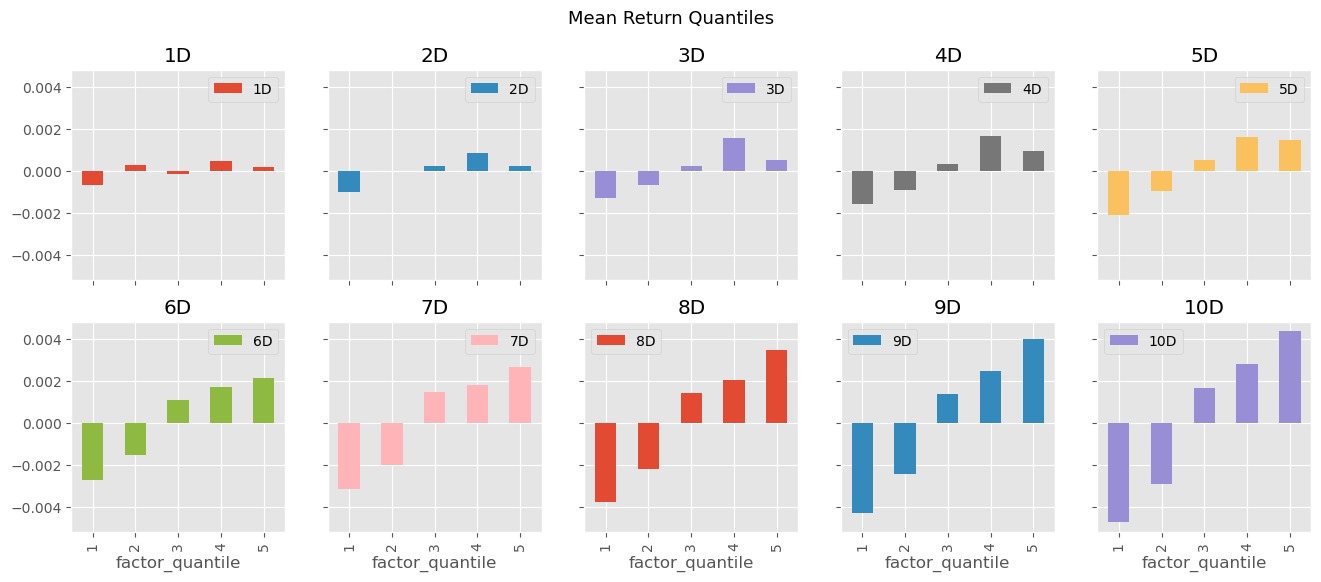

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 6), sharey=True, sharex=True)
mean_ret_quant_df.plot.bar(subplots=True, ax=axes)
fig.suptitle('Mean Return Quantiles', fontsize=13)
plt.show()

In [22]:
MeanRetQuantileByDate = lambda x: al.utils.demean_forward_returns(x)\
                                                .groupby(['factor_quantile', x.index.get_level_values('date')])[x.columns[:-2]]\
                                                .agg(['mean', 'std', 'count'])\
                                                .T.xs('mean', level=1).T


StdRetQuantileByDate = lambda x: al.utils.demean_forward_returns(x)\
                                                .groupby(['factor_quantile', x.index.get_level_values('date')])[x.columns[:-2]]\
                                                                    .agg(['mean', 'std', 'count'])\
                                                                    .T.xs('std', level=1).T

In [23]:
MeanRetQuantileByDate(alpha_data)

1D        2D        3D        4D        5D  \
factor_quantile date                                                           
1               2019-08-23  0.000167 -0.018013 -0.014693 -0.013081 -0.016727   
                2019-08-26 -0.021859 -0.014317 -0.015972 -0.020712 -0.013130   
                2019-08-27  0.007929  0.006186  0.001532  0.009252 -0.004984   
                2019-08-28  0.003167  0.005299  0.011704 -0.002543 -0.004214   
                2019-08-29 -0.004558  0.002879 -0.011319 -0.007468  0.000725   
...                              ...       ...       ...       ...       ...   
5               2024-07-19  0.020736  0.027287 -0.019376 -0.007141 -0.007904   
                2024-07-22  0.006084 -0.026714 -0.001991 -0.014553 -0.009204   
                2024-07-23 -0.044631 -0.032695 -0.034003 -0.028106 -0.056872   
                2024-07-24  0.013842  0.027282  0.020797  0.027554  0.023325   
                2024-07-25 -0.010343 -0.001876 -0.000562 -0.021017 -0.025976   

                                  6D        7D        8D        9D       10D  
factor_quantile date                                                          
1               2019-08-23 -0.014231 -0.018451 -0.012690 -0.001580 -0.004297  
                2019-08-26 -0.027529 -0.023953 -0.015662 -0.019317 -0.020647  
                2019-08-27 -0.001488  0.006594  0.002365  0.000984 -0.005390  
                2019-08-28  0.004626 -0.003245 -0.001598 -0.004502  0.003751  
                2019-08-29 -0.003078 -0.004273 -0.010587 -0.005417 -0.002545  
...                              ...       ...       ...       ...       ...  
5               2024-07-19 -0.001835 -0.031560  0.003652 -0.015993 -0.013645  
                2024-07-22 -0.015087 -0.014331 -0.023574 -0.027085 -0.026182  
                2024-07-23 -0.022901 -0.041752 -0.038255 -0.046221 -0.038148  
                2024-07-24  0.034749  0.027189  0.031439  0.034843  0.043511  
                2024-07-25 -0.012103 -0.007520 -0.009712 -0.012576 -0.018241  

[6190 rows x 10 columns]

In [24]:
from alphalens.plotting import*

### 6D Holding Period

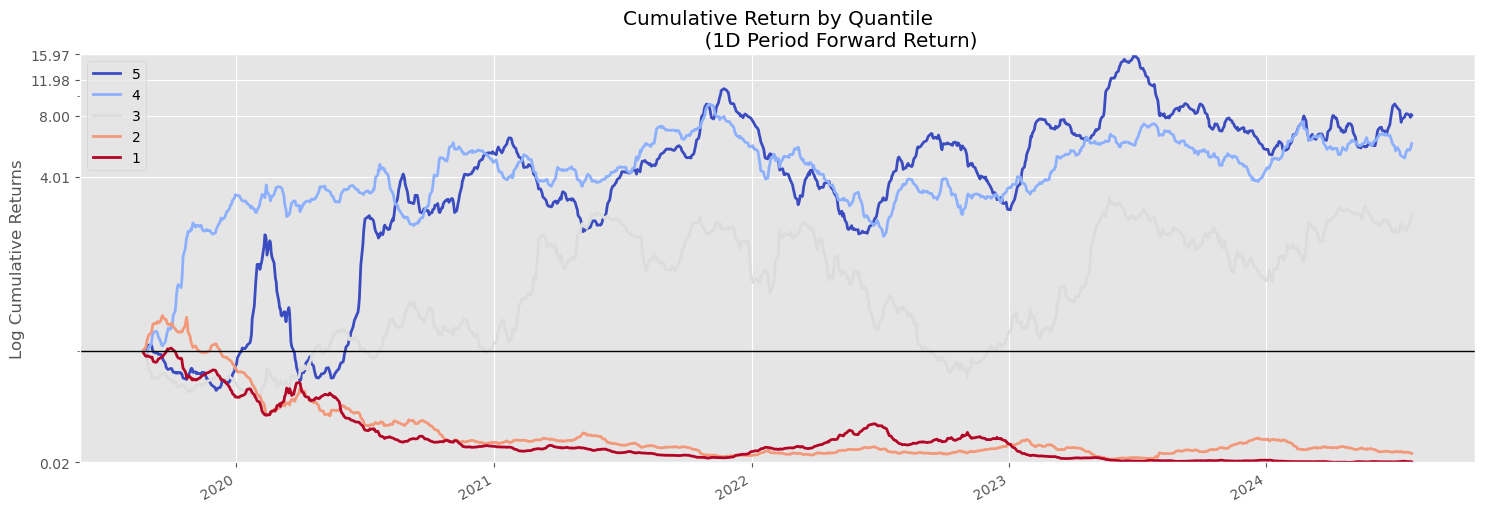

In [27]:
plot_cumulative_returns_by_quantile(MeanRetQuantileByDate(alpha_data)['6D'], period='1D')

plt.show()

### 7D Holding Period

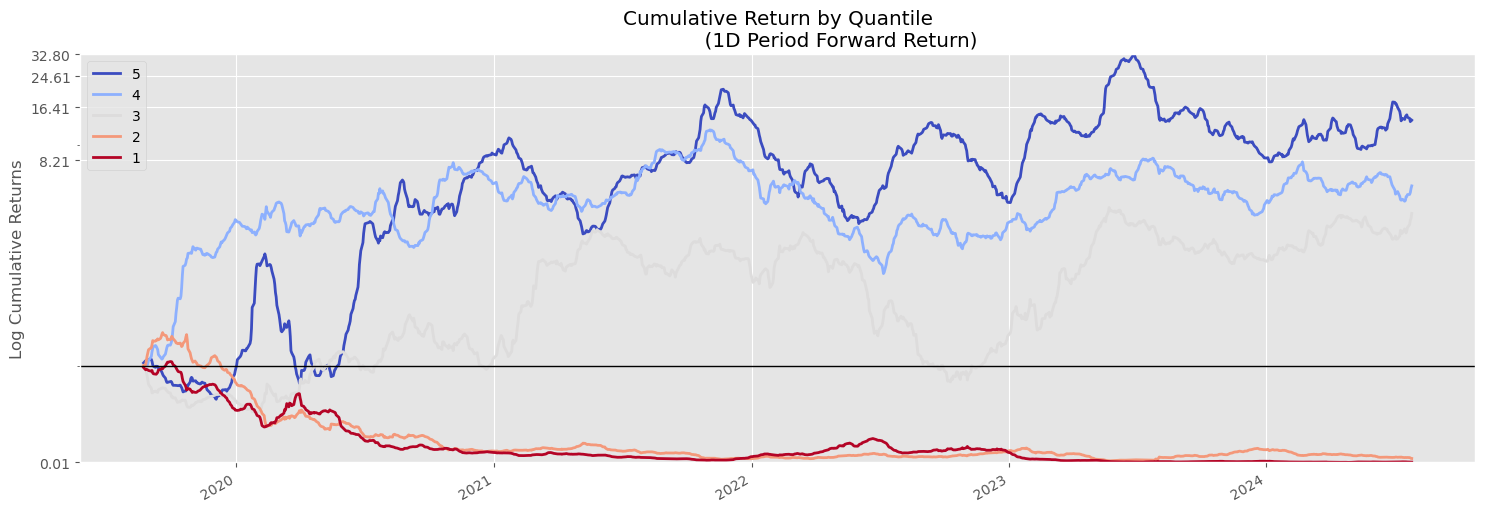

In [28]:
plot_cumulative_returns_by_quantile(MeanRetQuantileByDate(alpha_data)['7D'], period='1D')

plt.show()

### 8D Holding Period

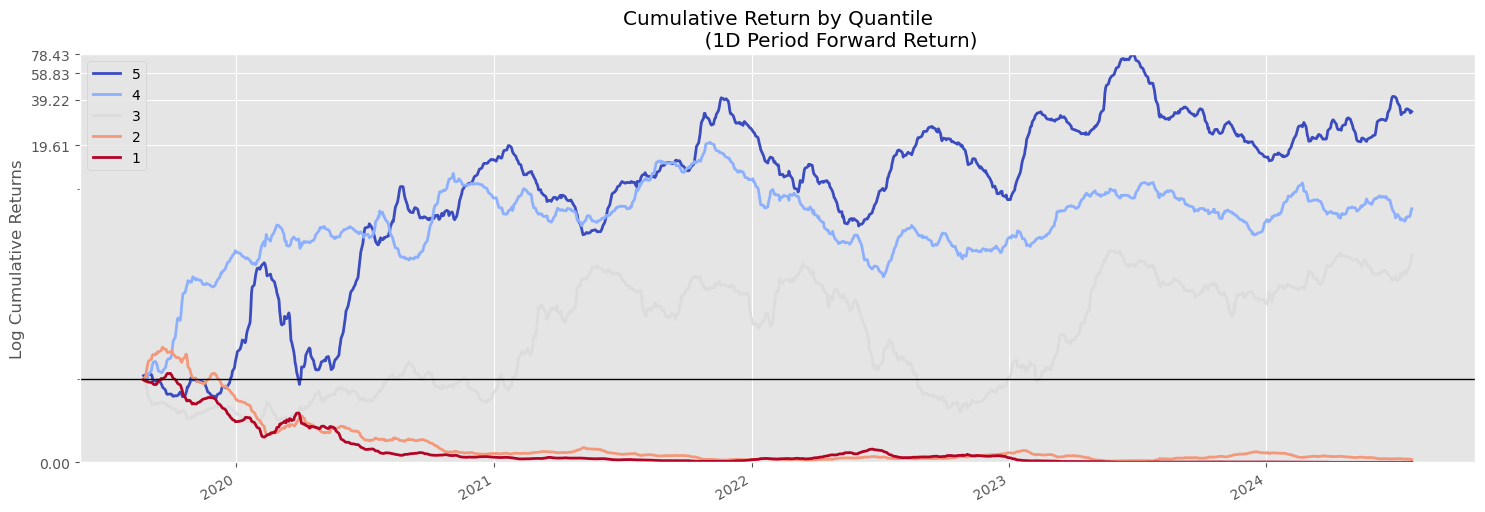

In [29]:
plot_cumulative_returns_by_quantile(MeanRetQuantileByDate(alpha_data)['8D'], period='1D')

plt.show()

### 9D Holding Period

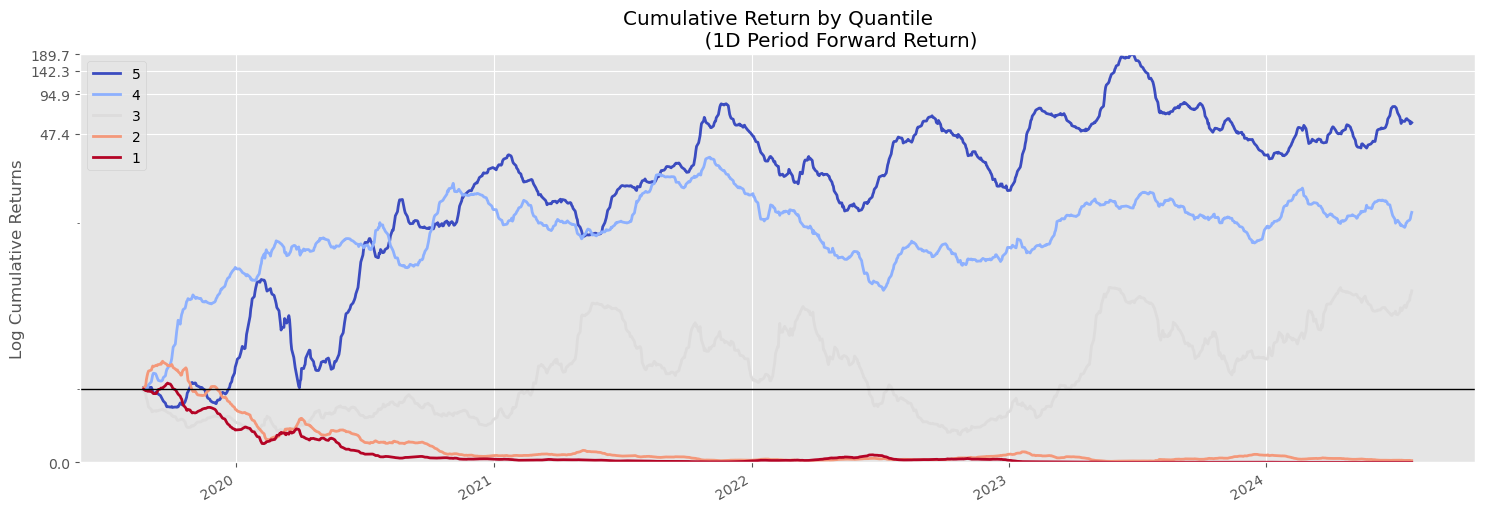

In [30]:
plot_cumulative_returns_by_quantile(MeanRetQuantileByDate(alpha_data)['9D'], period='1D')

plt.show()

### 10D Holding Period

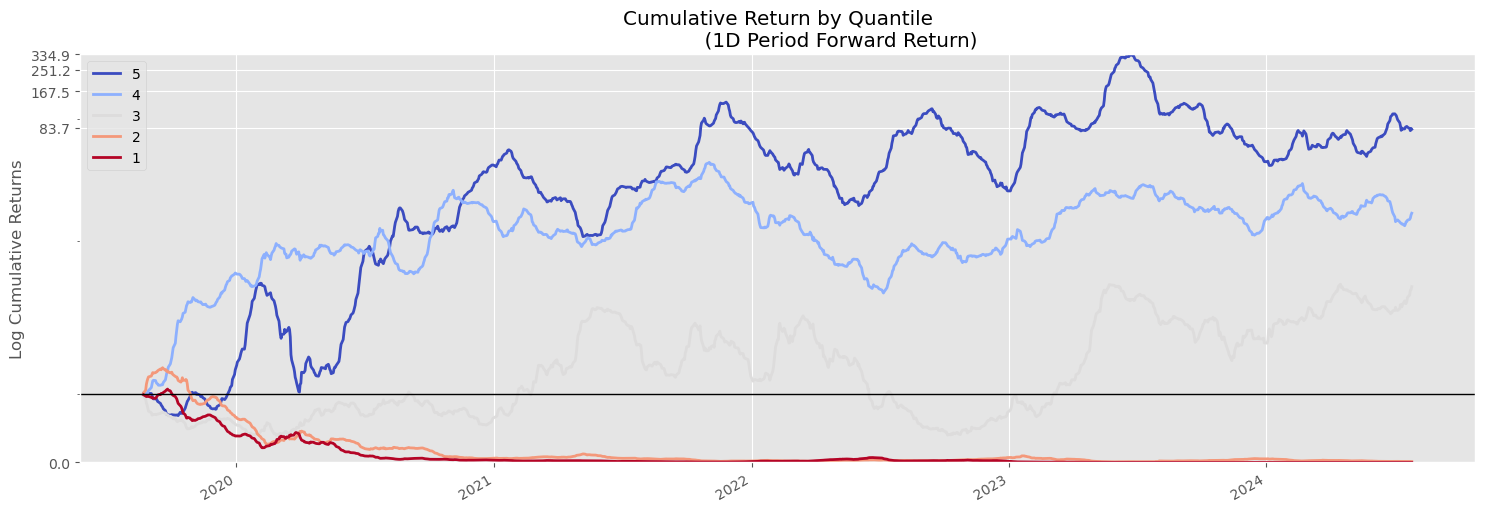

In [31]:
plot_cumulative_returns_by_quantile(MeanRetQuantileByDate(alpha_data)['10D'], period='1D')

plt.show()

# Turnover Analysis

<Axes: xlabel='date'>

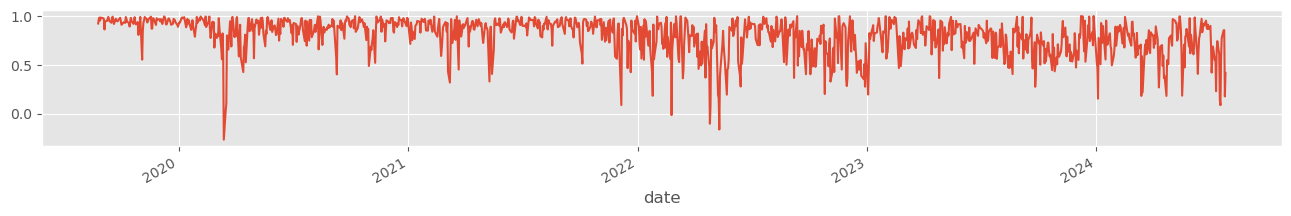

In [32]:
alpha_factor_FRA = al.performance.factor_rank_autocorrelation(alpha_data)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 2))
alpha_factor_FRA.plot(ax=axes)


# Turnover Per Quantile

In [33]:
periods  =  list(alpha_data.columns[:-2])
grouped = alpha_data.groupby(['date', 'factor_quantile'])
quantile_assets = {}


for (date, quantile), group in grouped:

    if date not in quantile_assets.keys():
        quantile_assets[date] = {}
    quantile_assets[date][quantile] = set(group.index.get_level_values('asset'))

dates = sorted(quantile_assets.keys())
dates_n = len(dates)
turnovers = {}
turnover_results = {period:{} for period in periods}

for period in periods:

    lag = int(period[0])
    for i in range(lag, dates_n):
        curr_date = dates[i]
        prev_date = dates[i - lag]
        turnovers[curr_date] = {}
         
        quantiles = set(quantile_assets[curr_date].keys()).union(set(quantile_assets[prev_date].keys()))

        for quantile in quantiles:
            curr_assets = quantile_assets[curr_date].get(quantile, set())
            prev_assets = quantile_assets[prev_date].get(quantile, set())

            num_changes = len(curr_assets - prev_assets) + len(prev_assets - curr_assets)
            total_assets = max(len(curr_assets), len(prev_assets))
            turnover = 0.5*num_changes / total_assets if total_assets > 0 else 0
            turnovers[curr_date][quantile] = turnover
    
    quantile_mean_turnover = pd.DataFrame(turnovers).T.mean().to_dict()
    turnover_results[period] = quantile_mean_turnover


turnover_df = pd.DataFrame(turnover_results).T
turnover_df.columns = ['Quantile 1 Mean Turnover', 
                       'Quantile 2 Mean Turnover', 
                       'Quantile 3 Mean Turnover', 
                       'Quantile 4 Mean Turnover',
                       'Quantile 5 Mean Turnover'
                       ]
turnover_df.T.round(3)

,1D,2D,3D,4D,5D,6D,7D,8D,9D,10D
Quantile 1 Mean Turnover,0.229,0.300,0.343,0.373,0.396,0.423,0.442,0.454,0.471,0.229
Quantile 2 Mean Turnover,0.417,0.502,0.535,0.566,0.580,0.593,0.607,0.618,0.630,0.417
Quantile 3 Mean Turnover,0.423,0.500,0.533,0.559,0.569,0.591,0.608,0.624,0.636,0.423
Quantile 4 Mean Turnover,0.400,0.455,0.490,0.510,0.526,0.544,0.553,0.564,0.573,0.400
Quantile 5 Mean Turnover,0.310,0.365,0.390,0.409,0.417,0.424,0.431,0.433,0.440,0.310


# Information Coefficient

In [34]:
ic = al.performance.factor_information_coefficient(alpha_data).dropna()
ic

,1D,2D,3D,4D,5D,6D,7D,8D,9D,10D
date,,,,,,,,,,
2019-08-23,0.075325,0.333225,0.238961,0.093506,0.214286,0.093506,0.487013,0.501299,0.184416,0.203896
2019-08-26,0.293506,0.114286,0.107792,0.164935,-0.054545,0.203896,0.388312,0.120779,0.124675,0.094805
2019-08-27,-0.400000,-0.210390,-0.124675,-0.374026,-0.062338,0.015584,-0.141558,-0.057143,-0.093506,-0.080519
2019-08-28,0.040260,-0.042857,-0.276623,0.015584,0.084416,-0.068831,-0.001299,-0.049351,-0.049351,-0.054545
2019-08-29,-0.072727,-0.311688,-0.098701,0.331169,-0.071429,0.061039,0.031169,0.054545,0.038961,0.033766
...,...,...,...,...,...,...,...,...,...,...
2024-07-19,0.301299,0.527273,0.181818,0.236364,0.244156,0.268831,0.190909,0.387013,0.271429,0.163636
2024-07-22,0.150649,-0.129870,0.124675,-0.041558,-0.027273,-0.057143,0.127273,-0.027273,-0.059740,-0.037662
2024-07-23,-0.266234,-0.136364,-0.014286,-0.001299,-0.112987,0.105195,0.031169,0.058442,0.055844,0.053247


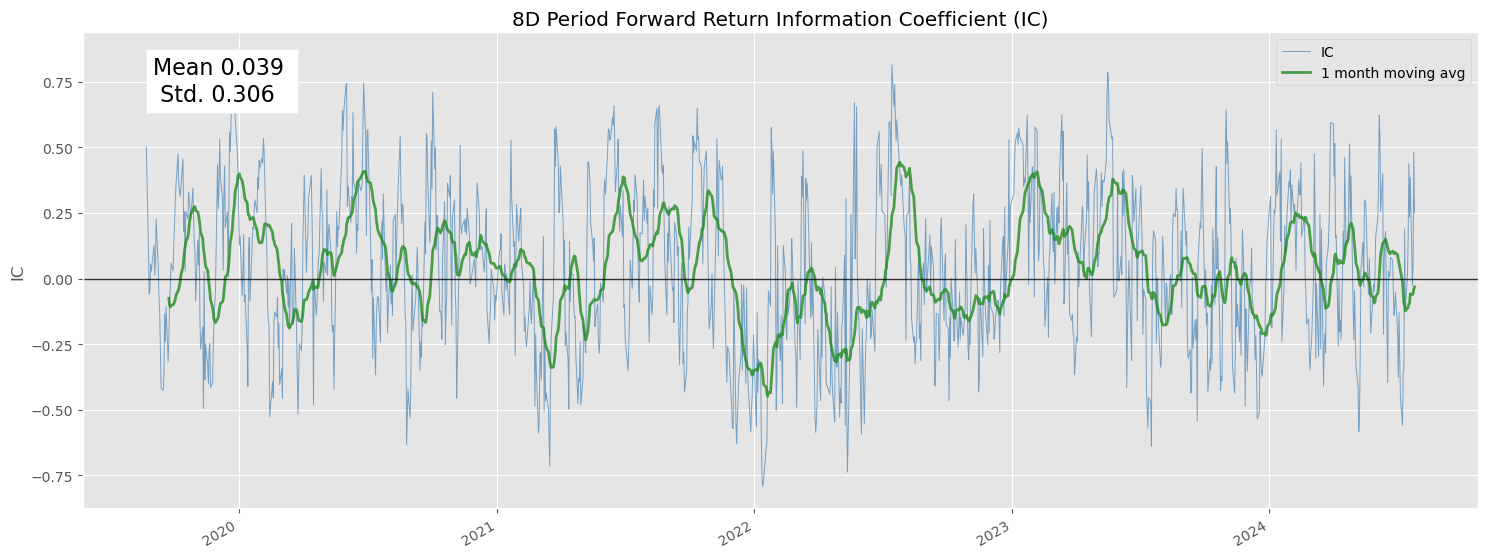

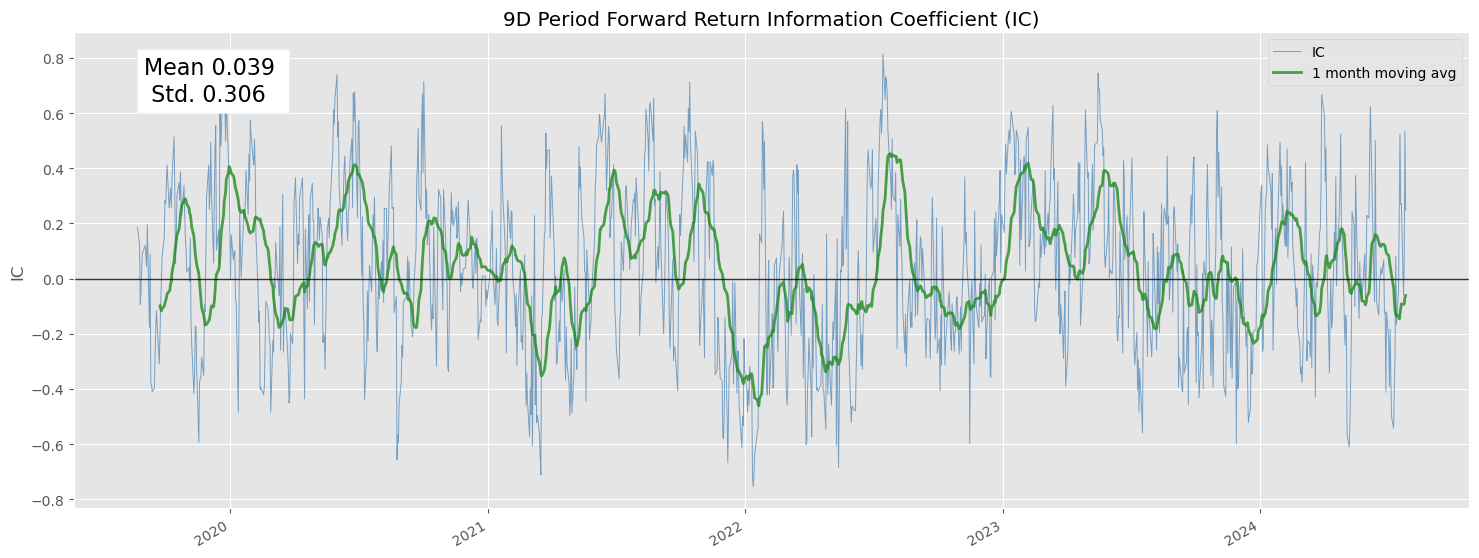

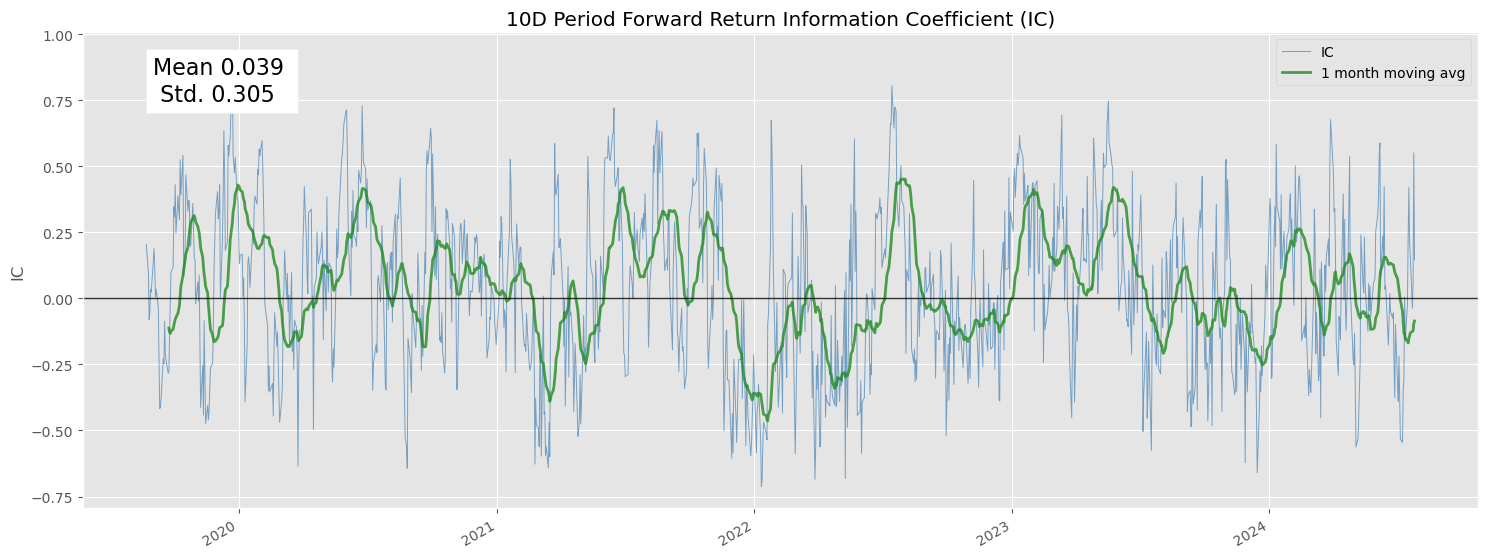

In [35]:
plot_ic_ts(ic[['8D']])
plot_ic_ts(ic[['9D']])
plot_ic_ts(ic[['10D']])
plt.show()

# Risk Mactor Model

The portfolio multifactor risk model is the standard deviation of the portfolio's return expressed in terms of the risk factors.

The variance of the portfolio is given by 
$$\mathrm{Var}(r_P) = \mathbf{X}^T \left(\mathbf{BFB}^T + \mathbf{S}\right)\mathbf{X}$$
where
- $ \mathbf{X}$ is the vector of lenght $N$ of the portfolio weights.
- $ \mathbf{B}$ is the $N \times K$ factor exposures.
- $ \mathbf{F}$ is the $K \times K$  factor covariance matrix.
- $ \mathbf{S}$ is $N \times N$ the idiosyncratic variance matrix.

 Modelling the risk of the portfolio is equilivant to estimating its standard deviation. Therefore,  calculating the variance and the standard deviation, using asset returns formula, yield the portfolio risk model as 
 $$ risk_P = \sqrt {\mathbf{X}^T \left(\mathbf{BFB}^T + \mathbf{S}\right)\mathbf{X}}$$

 **Note**: The portfolio risk model is crucial for designing an optimal portfolio. In fact, the risk model will be use as an optimal constrain for choosing the level of allowed risk  that will maximize the portfolio returns.

 

In [36]:
# download Fama-French 5-factor model
factor_data = (web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', 
                              start=2019, end=2024)[0].rename(columns={'Mkt-RF': 'MARKET'}))
factor_data.index.names = ['date']
factor_data.drop(['RF'], axis=1, inplace=True)
factor_names = factor_data.columns
factor_data

,MARKET,SMB,HML,RMW,CMA
date,,,,,
2019-01-02,0.23,0.74,1.12,-0.12,0.27
2019-01-03,-2.45,0.48,1.20,-0.22,0.90
2019-01-04,3.55,0.36,-0.70,-0.11,-0.59
2019-01-07,0.94,0.87,-0.75,-0.72,-0.45
2019-01-08,1.01,0.44,-0.63,0.31,-0.09
...,...,...,...,...,...
2023-12-22,0.20,0.61,0.10,-0.65,0.20
2023-12-26,0.48,0.83,0.43,-0.33,-0.16
2023-12-27,0.16,0.17,0.10,-0.32,-0.14


In [37]:
# returns 
close = data['Adj Close'].unstack()
chosen_days = 10
ret = close.pct_change(chosen_days).dropna().unstack()
ret.name = 'return'
ret.rename_axis(index={'Date':'date'}, inplace=True)
#print(ret)

# join returns and risk factors
fama_fac_and_return = factor_data.join(ret)
#print(fama_fac_and_return)

# collect the date index for future use
#date_idx = fama_fac_and_return['return'].index.unique('date')
#print(date_idx)


In [39]:
factor_betas, specific_returns = optimization_module.factor_betas_and_specific_return(fama_fac_and_return, factor_data)

In [40]:
factor_betas

,MARKET,SMB,HML,RMW,CMA
Ticker,,,,,
AAPL,0.011570,-0.000716,-0.006375,0.006082,0.006389
AEM,0.008369,0.001469,-0.008694,-0.000447,0.020233
AMD,0.015659,0.001024,-0.004969,0.001983,-0.003199
AMZN,0.009998,-0.001028,-0.003698,-0.002599,-0.007029
BAC,0.012569,0.001058,0.013469,-0.005062,0.001133
CPB,0.002830,-0.000783,-0.003128,0.000992,0.013888
EGO,0.007033,-0.001775,-0.005878,-0.012810,0.024346
GE,0.011791,0.001726,0.011718,-0.009006,0.001619
GOLD,0.005724,-0.001626,-0.008132,-0.003034,0.019694


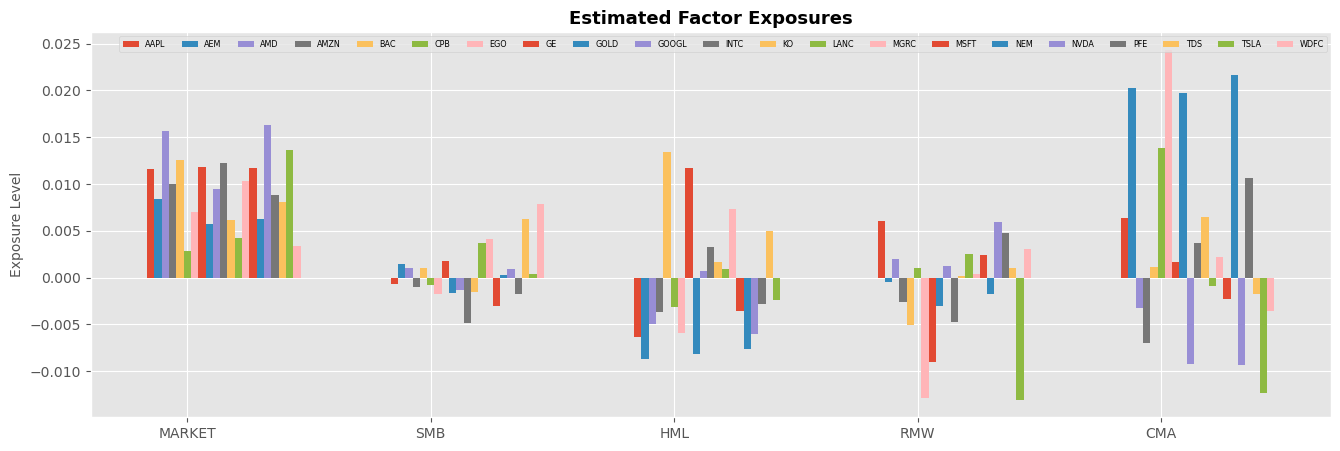

In [41]:
ticker_list = list(factor_betas.index)
fig, ax = plt.subplots(figsize=(16, 5))
num_tickers = len(ticker_list)
num_factors = len(factor_names)
bar_width = 0.03
indices = np.arange(num_factors)

for i, ticker in enumerate(ticker_list):
    bar_positions = indices + i * bar_width
    ax.bar(bar_positions, factor_betas.loc[ticker], width=bar_width, label=ticker)

ax.set_ylabel('Exposure Level', fontsize=10)
ax.set_xticks(indices + bar_width * (num_factors))
ax.set_xticklabels(factor_names)              

ax.set_title('Estimated Factor Exposures', fontsize=13, fontweight='bold')
ax.legend(ncol=len(ticker_list), fontsize=5.8)
plt.show()


In [42]:
specific_returns

Ticker,AAPL,AEM,AMD,AMZN,BAC,CPB,EGO,GE,GOLD,GOOGL,...,KO,LANC,MGRC,MSFT,NEM,NVDA,PFE,TDS,TSLA,WDFC
date,,,,,,,,,,,,,,,,,,,,,
2019-08-22,0.049334,0.000102,-0.054827,-0.010515,-0.046045,0.036968,0.030847,-0.139312,0.029818,-0.009937,...,0.012473,0.012986,-0.012840,-0.002730,-0.021118,0.089500,-0.050746,-0.072225,-0.058914,0.010263
2019-08-23,0.042703,0.065581,-0.094190,-0.010123,-0.031934,0.031711,0.128497,-0.099603,0.070632,-0.006696,...,0.023481,-0.001269,0.001501,0.001583,0.026323,0.097881,-0.027979,-0.024477,-0.075656,-0.008977
2019-08-26,0.016180,0.035601,-0.084879,-0.021010,-0.041236,0.011344,0.113661,-0.119234,0.067187,-0.014563,...,0.019686,-0.002595,-0.022861,-0.013399,0.021304,0.071272,-0.024845,-0.030796,-0.075622,-0.004215
2019-08-27,-0.024836,0.090136,-0.054946,-0.032014,-0.027808,-0.007817,0.175979,-0.134435,0.086581,-0.017879,...,0.024744,-0.085337,-0.026738,-0.017952,0.078986,0.040185,-0.026014,-0.024327,-0.079580,-0.014226
2019-08-28,0.006831,0.089040,0.009652,-0.000778,0.000205,0.009547,0.116164,-0.134340,0.095863,0.003637,...,0.034303,-0.061889,-0.033638,0.007571,0.072725,0.067417,0.017502,-0.015654,-0.019365,-0.008222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,-0.009346,0.073197,0.081511,0.039414,0.071758,0.000189,0.050319,0.039824,0.076345,0.049689,...,-0.006591,-0.022709,0.143697,0.002850,0.070130,0.030389,-0.012705,-0.028615,0.026922,-0.001125
2023-12-26,0.000138,0.085251,0.060872,0.047208,0.083377,-0.016208,0.082473,0.044933,0.094230,0.056982,...,-0.009446,-0.021603,0.136252,0.007912,0.081137,0.051362,-0.006368,-0.011057,0.058243,0.011533
2023-12-27,-0.006263,0.116086,0.059482,0.036863,0.095847,-0.032438,0.112044,0.042722,0.132315,0.057004,...,-0.011876,-0.027332,0.110423,-0.001372,0.124247,0.035353,0.003217,0.015049,0.095168,0.012396


# Get Optimal Weights


We will maximize the objective function $$ \alpha^T * x + \lambda\|x\|_2\\ $$ 
under the constraints

- $ risk_p^2 \leq risk_{\text{cap}}^2 \\ $
- $ B^T * x \preceq factor_{\text{max}} \\ $
- $ B^T * x \succeq factor_{\text{min}} \\ $
- $ x^T\mathbb{1} = 0 \\ $
- $ \|x\|_1 \leq 1 \\ $
- $ x \succeq weights_{\text{min}} \\ $
- $ x \preceq weights_{\text{max}} $


where $ x $ is the portfolio weights, $ \alpha $ is the alpha vector, $ \lambda $ is the regularization parameter, $ B $ is the factor betas, and $ risk_P^2 $ is the portfolio risk.



In [43]:
alpha_vector = alpha_data[['factor']].loc[fama_fac_and_return.index.unique('date')[-1]]

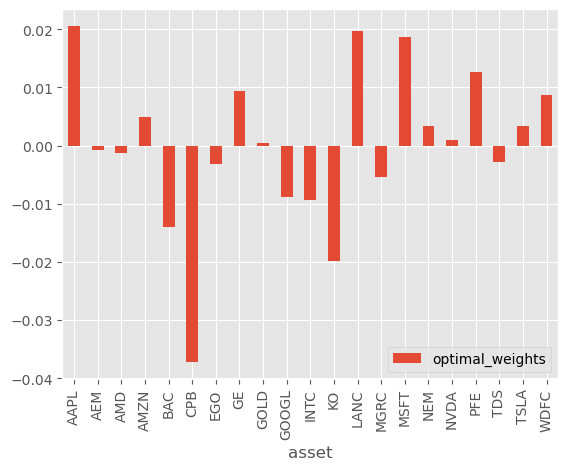

,optimal_weights
asset,
AAPL,0.020583
AEM,-0.000808
AMD,-0.001254
AMZN,0.004956
BAC,-0.014070
CPB,-0.037197
EGO,-0.003192
GE,0.009330
GOLD,0.000404


In [45]:
op_weights = optimization_module.get_optimal_weights(alpha_vector, fama_fac_and_return, factor_data)
op_weights.plot.bar()
plt.show()
op_weights

# Transfer Coefficient
The transfer coefficient measures how closely the optimized portfolio weights align with the original alpha vector.
$$\text{TC} = \mathrm{corr}\left(\alpha, x\right).$$

For the transfer coefficient to be meaningful, the portfolio optimization process should incorporate a risk factor model, which is the case here.

Ideally, one aims to preserve the information in the alpha vector through optimization by obtaining portfolio weights that remain correlated with the alpha signals. This would indicate that the expected performance captured by the alpha vector has been effectively transferred to the portfolio. In other words, the alpha factor should remain independent of the risk factors. Otherwise, the risk model could neutralize the alpha signals, leading to substantial shifts in the portfolio weights after optimization.

Tranfer Coefficient (TC):  0.84


       Alpha Vector  Optimal weights
asset                               
AAPL       1.450481         0.020583
AEM       -0.161165        -0.000808
AMD       -0.322329        -0.001254
AMZN       0.483494         0.004956
BAC       -1.450481        -0.014070
CPB       -1.611646        -0.037197
EGO       -0.966988        -0.003192
GE         1.289317         0.009330
GOLD       0.000000         0.000404
GOOGL     -0.644658        -0.008759
INTC      -1.128152        -0.009389
KO        -0.805823        -0.019848
LANC       1.128152         0.019633
MGRC      -0.483494        -0.005328
MSFT       0.966988         0.018605
NEM        0.322329         0.003452
NVDA       0.161165         0.000901
PFE        0.805823         0.012646
TDS       -1.289317        -0.002760
TSLA       1.611646         0.003384
WDFC       0.644658         0.008713


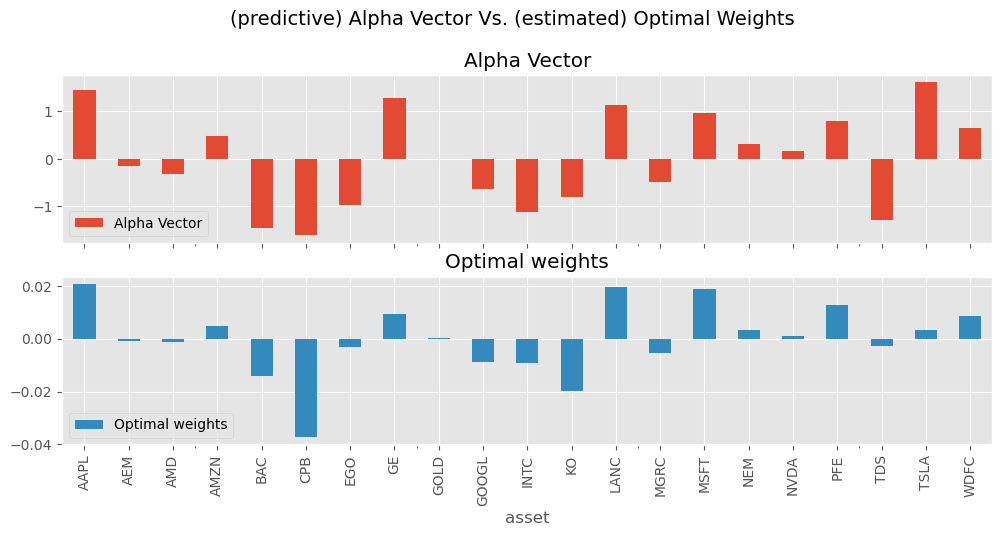

In [46]:
def transfer_coef(alpha_vector, optimal_weights):
    
    alphavec_vs_optimalweights = alpha_vector.join(optimal_weights)
    alphavec_vs_optimalweights.rename(columns={'factor': 'Alpha Vector', 'optimal_weights':'Optimal weights'}, inplace=True)

    TC = alphavec_vs_optimalweights['Alpha Vector'].corr(alphavec_vs_optimalweights['Optimal weights'])
    print(f"Tranfer Coefficient (TC):  {TC:.2f}")
    print('\n')
    print(alphavec_vs_optimalweights)

    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 5))
    alphavec_vs_optimalweights.plot.bar(subplots=True, ax=ax)
    fig.suptitle('(predictive) Alpha Vector Vs. (estimated) Optimal Weights', fontsize=14)
    fig.subplots_adjust(top=.85)

    plt.show()

transfer_coef(alpha_vector=alpha_vector, optimal_weights=op_weights)

The graph above shows a strongly similar trend between alpha values and corresponding optimal weights for every stock. 

This confirms the high transfer coeffient of  $0.84$

# Removing Assets and Optimize 

To design an optimal portfolio, we may want to avoid `strong short positions` as shoring tend to be riskier. For that, we will remove stocks that require strong short positions and re-run the optimization for new optimal weights.

In [49]:
def drop_assets_and_optimize_again(droped_assets):
    '''
        droped_assets: list of remove assets 
    '''
    opt_wights_ = optimization_module.get_optimal_weights(alpha_vector.drop(droped_assets), fama_fac_and_return.drop(droped_assets), factor_data)
    opt_wights_.plot.bar()
    plt.show()
    print(opt_wights_)

    return opt_wights_


- We decide to remove the assets `CPB`  `KO` and `BAC`, as they require the highests amount of `short position fees`.
- We remove `GOLD` as its expected return predicted by the alpha is null.
- We remove the asset `WDFC` because it has a very low volume, even though a long position was suggested.

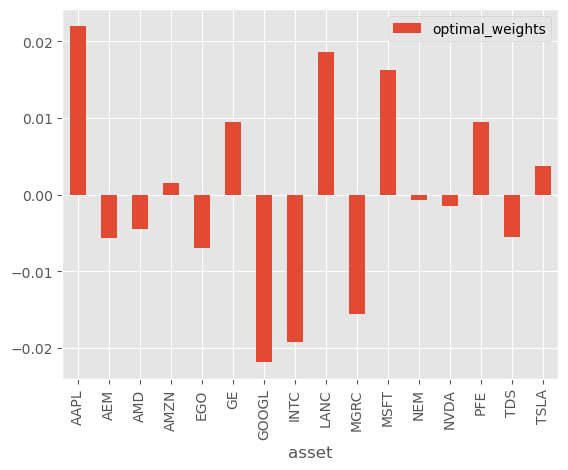

       optimal_weights
asset                 
AAPL          0.022033
AEM          -0.005632
AMD          -0.004481
AMZN          0.001568
EGO          -0.006918
GE            0.009502
GOOGL        -0.021847
INTC         -0.019275
LANC          0.018676
MGRC         -0.015575
MSFT          0.016285
NEM          -0.000686
NVDA         -0.001474
PFE           0.009512
TDS          -0.005480
TSLA          0.003792


In [50]:
dropped_asset_list = ['CPB', 'KO', 'BAC', 'GOLD', 'WDFC']

opt_weights =  drop_assets_and_optimize_again(dropped_asset_list)


Tranfer Coefficient (TC):  0.84


       Alpha Vector  Optimal weights
asset                               
AAPL       1.450481         0.022033
AEM       -0.161165        -0.005632
AMD       -0.322329        -0.004481
AMZN       0.483494         0.001568
EGO       -0.966988        -0.006918
GE         1.289317         0.009502
GOOGL     -0.644658        -0.021847
INTC      -1.128152        -0.019275
LANC       1.128152         0.018676
MGRC      -0.483494        -0.015575
MSFT       0.966988         0.016285
NEM        0.322329        -0.000686
NVDA       0.161165        -0.001474
PFE        0.805823         0.009512
TDS       -1.289317        -0.005480
TSLA       1.611646         0.003792


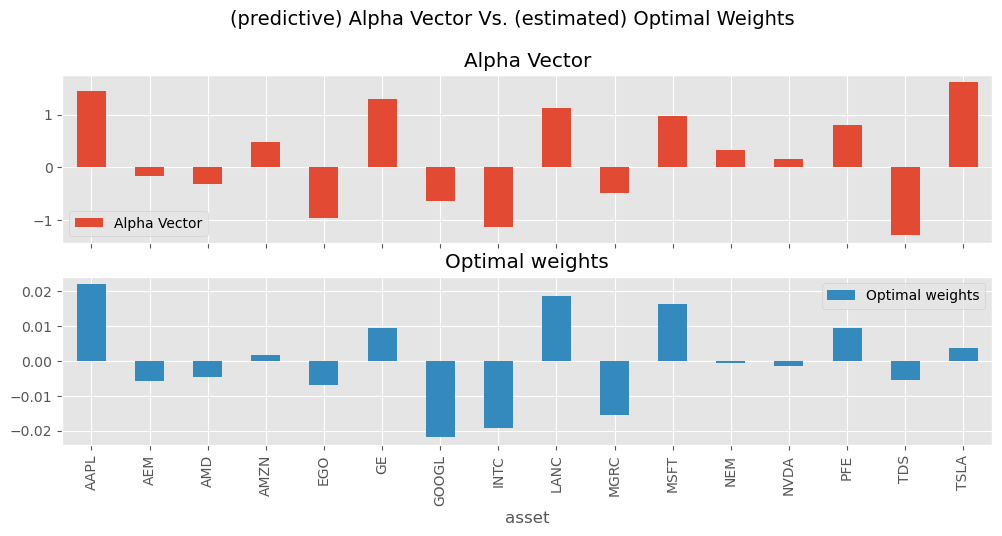

In [51]:
new_alpha_vector = alpha_vector.drop(dropped_asset_list)
transfer_coef(alpha_vector=new_alpha_vector, optimal_weights=opt_weights)

# Conclusion

We have successfully developed an end-to-end portfolio construction process and designed an optimal portfolio.

The alignment between the signal from the alpha vector and the portfolio's optimal weights confirms the effectiveness of our strategy. This positive outcome suggests that the alpha factors were not correlated with the risk factors driving volatility, allowing the portfolio to retain the alpha signal post-optimization.

As the next step, we will conduct a backtesting procedure to simulate the portfolio's return performance under real market price dynamics. This will help validate the robustness of our strategy in various market conditions.